In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Specify the file path to the SQLite database file
db_path = '/Users/elizabethmorgan/Documents/GitHub/sqlalchemy-challenge/Resources/hawaii.sqlite'

# Create SQLAlchemy engine with the correct file path
engine = create_engine(f"sqlite:///{db_path}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(most_recent_date)

2017-08-23


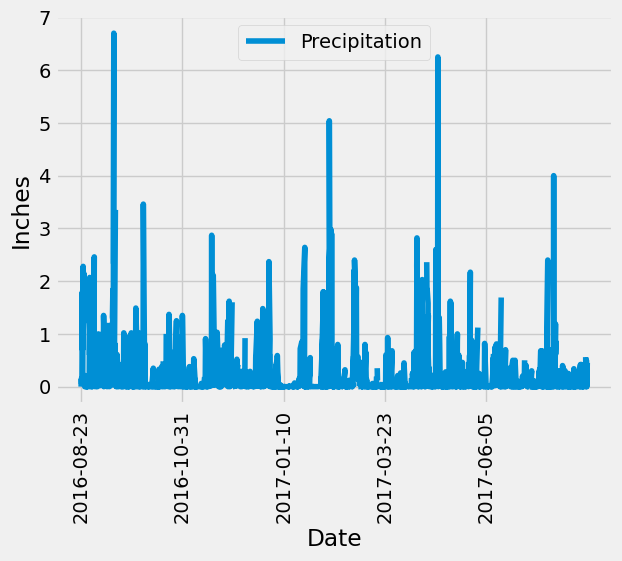

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

# Convert the most_recent_date string to a datetime object
most_recent_date_dt = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in the dataset using timedelta
one_year_prior_dt = most_recent_date_dt - timedelta(days=365)

# Convert the one_year_prior_dt back to a string
one_yr_prior = one_year_prior_dt.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
relevant_dates = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) <= most_recent_date).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= one_yr_prior).\
    order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
dates_df = pd.DataFrame(relevant_dates, columns=["Date", "Precipitation"])

# Sort the dataframe by date
dates_df = dates_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
locs = np.arange(len(dates_df['Date']))
xticks = [d for d in dates_df['Date']]
dates_df.plot()
plt.xticks(locs, xticks, rotation=90)
plt.locator_params(axis='x', nbins=5)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_df = pd.DataFrame(dates_df['Precipitation'].describe())
summary_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).distinct().count()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_cts = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
station_cts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_cts[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

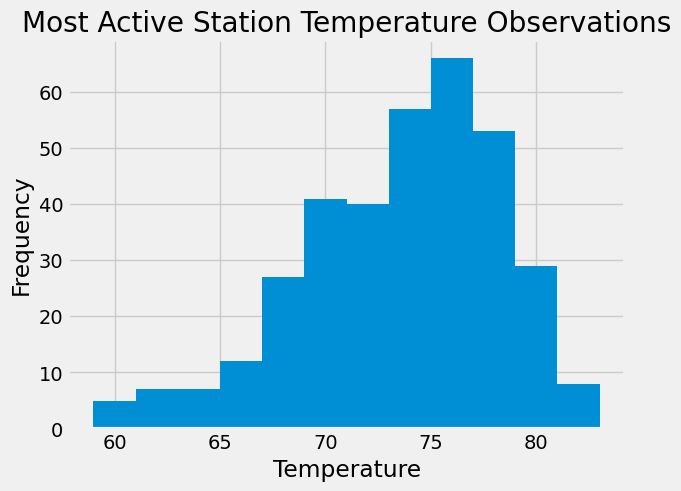

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) <= most_recent_date).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= one_yr_prior).\
    filter(Measurement.station == station_cts[0][0]).\
    order_by(Measurement.date.asc()).all()
most_active_tobs_df = pd.DataFrame(tobs_data, columns=["Temperature"])
plt.hist(most_active_tobs_df["Temperature"], bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Most Active Station Temperature Observations")
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()